# Permeation barrier model

Base model for shield permeation barrier modeling

In [1]:
import festim as F
import numpy as np
from timelag_analysis_functions import *

In [2]:
my_model = F.HydrogenTransportProblem()

substrate_thick = 1e-3  # m
my_model.temperature = 600
w_atom_density = 6.3e28  # atom/m3
final_time = 1.2e5  # s

tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
    )

In [3]:
# run_length = 1.2e5  # s
# bake_length = 2.88e4  # s 8hrs
# # milestones = [run_length, run_length + bake_length, 2*run_length + bake_length, 2*run_length + 2*bake_length, 3*run_length + 2*bake_length]


# def temp_fun(t):
#     if t<= run_length:


In [ ]:

H, trapped_H1, trapped_H2, empty_trap1, empty_trap2 = define_species(my_model, w_atom_density)

vertices = np.linspace(0, substrate_thick, num=50)

my_model.mesh = F.Mesh1D(vertices)

volume_subdomain, left_boundary, right_boundary = define_BCs_and_initial_conditions(my_model, tungsten, substrate_thick, H)

define_trapping_reactions(my_model, H, trapped_H1, trapped_H2, empty_trap1, empty_trap2, volume_subdomain, w_atom_density)

settings(my_model, final_time)

permeation_flux = F.SurfaceFlux(field=H, surface=right_boundary)

my_model.exports = [permeation_flux]



total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)

# left_flux = F.SurfaceFlux(surface=left_boundary, field=H)
# right_flux = F.SurfaceFlux(surface=right_boundary, field=H)
# total_mobile_H = F.TotalVolume(field=H, volume=volume_subdomain)
# total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)
# total_trapped_H2 = F.TotalVolume(field=trapped_H2, volume=volume_subdomain)




my_model.initialise()

my_model.run()



# profile_exports = [
#     F.Profile1DExport(
#         field=spe,
#     )
#     for spe in [H, trapped_H1, trapped_H2]
# ]

# my_model.exports = [
#     total_mobile_H,
#     total_trapped_H1,
#     total_trapped_H2,
#     left_flux,
#     right_flux,
# ] + profile_exports

Solving HydrogenTransportProblem: 100%|██████████| 120k/120k [00:06<00:00, 18.7kit/s] 


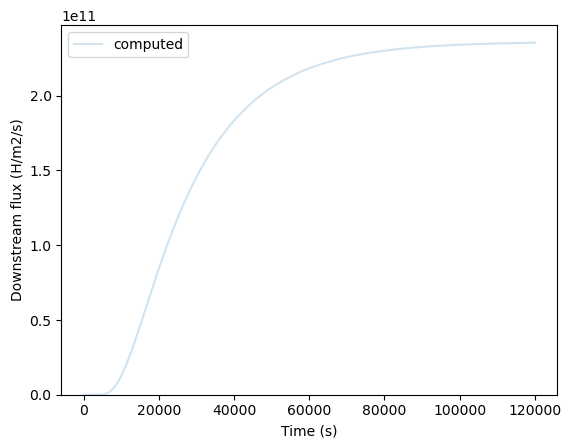

In [5]:
times = permeation_flux.t

import matplotlib.pyplot as plt

plt.plot(times, np.abs(permeation_flux.data), alpha=0.2, label="computed")
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.legend()
plt.show()